In [ ]:
# -*- coding: utf-8 -*-
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
# implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

# Lung cancer classification using CNN
### Author: Sebastián Čambál (2022)

## Dataset
https://www.kaggle.com/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset

The IQ-OTH/NCCD lung cancer dataset, 157 MB of CT scan slices images
3 classes: malignant, benign, normal

Data source reference: Alyasriy, Hamdalla; AL-Huseiny, Muayed (2021), “The IQ-OTHNCCD lung cancer dataset”, Mendeley Data, V2, [DOI: 10.17632/bhmdr45bh2.2](https://data.mendeley.com/datasets/bhmdr45bh2/2)

**Classification of lung cancer images into 3 classes: normal, malignant and begnin cases. We solve the task using a convolutional neural network (CNN).**

In [4]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential

In [5]:
IMAGE_SIZE = 256
BATCH_SIZE = 30

## EDA
First, we will start with the visualization of CT scans.

The typo "bengin" is found instead of the word "benign" throughout the dataset.

In [6]:
normal_imgs = [fn for fn in os.listdir(path='The IQ-OTHNCCD lung cancer dataset/Normal cases') if fn.endswith('.jpg')]
benign_imgs = [fn for fn in os.listdir(path='The IQ-OTHNCCD lung cancer dataset/Bengin cases') if fn.endswith('.jpg')]
malignant_imgs = [fn for fn in os.listdir(path='The IQ-OTHNCCD lung cancer dataset/Malignant cases') if fn.endswith('.jpg')]
print(f'Num. normal: {len(normal_imgs)}, num. bengin: {len(benign_imgs)}, num. malignant: {len(malignant_imgs)}')

Num. normal: 416, num. bengin: 120, num. malignant: 561


In [7]:
normal_selection = np.random.choice(normal_imgs, 3, replace = False)
benign_selection = np.random.choice(benign_imgs, 3, replace = False)
malignant_selection = np.random.choice(malignant_imgs, 3, replace = False)

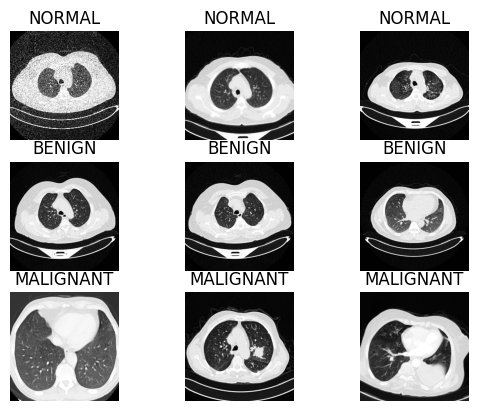

In [8]:
fig = plt.figure()
for i in range(9):
    if i < 3:
        fp = f'The IQ-OTHNCCD lung cancer dataset/Normal cases/{normal_selection[i]}'
        label = 'NORMAL'
    elif i>=3 and i < 6:
        fp = f'The IQ-OTHNCCD lung cancer dataset/Bengin cases/{benign_selection[i-3]}'
        label = 'BENIGN'
    else:
        fp = f'The IQ-OTHNCCD lung cancer dataset/Malignant cases/{malignant_imgs[i-6]}'
        label = 'MALIGNANT'
    ax = fig.add_subplot(3, 3, i+1)
    
    # to plot without rescaling, remove target_size
    fn = image.load_img(fp, target_size = (IMAGE_SIZE,IMAGE_SIZE), color_mode='grayscale')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.show()

In [9]:
def img2np(path, list_of_filename, size=(IMAGE_SIZE, IMAGE_SIZE)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size = size, color_mode = 'grayscale')
        # convert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

normal = img2np('The IQ-OTHNCCD lung cancer dataset/Normal cases/', normal_imgs)
benign = img2np('The IQ-OTHNCCD lung cancer dataset/Bengin cases/', benign_imgs)
malignant = img2np('The IQ-OTHNCCD lung cancer dataset/Malignant cases/', malignant_imgs)

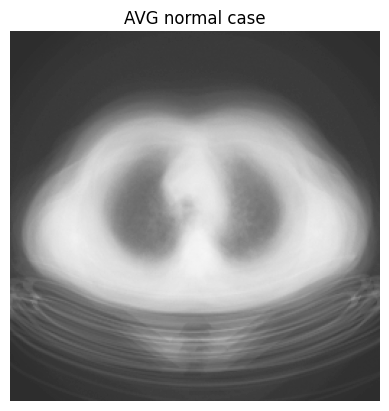

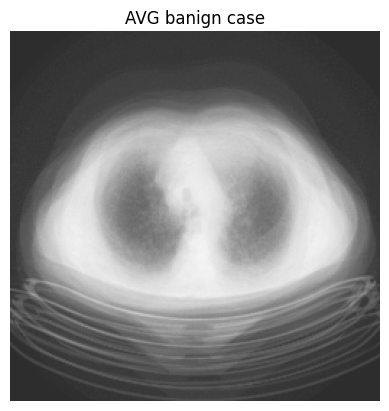

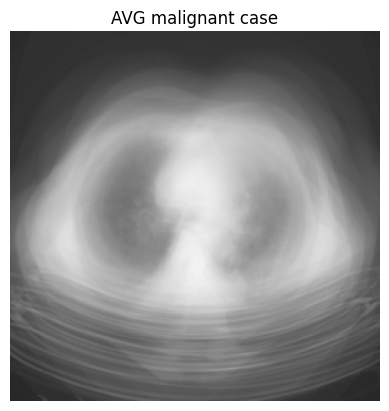

In [10]:
def find_mean_img(full_mat, title, size=(IMAGE_SIZE, IMAGE_SIZE)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'AVG {title} case')
    plt.axis('off')
    plt.show()
    return mean_img

norm_mean_img = find_mean_img(normal, 'normal')
benign_mean_img = find_mean_img(benign, 'banign')
malignant_mean_img = find_mean_img(malignant, 'malignant')

## Creating a dataset

In [11]:
ds = tf.keras.preprocessing.image_dataset_from_directory(
    'The IQ-OTHNCCD lung cancer dataset',
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1097 files belonging to 3 classes.


In [12]:
classes = ds.class_names
print(f'Classes for classification: {str(classes)}')

Classes for classification: ['Bengin cases', 'Malignant cases', 'Normal cases']


In [13]:
def splitDataset(data, train_split=0.7, val_split=0.2, test_split=0.1):
    data_size = len(data)
    train_size = int(train_split * data_size)
    val_size = int(val_split * data_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = splitDataset(ds)

In [14]:
input_shape = None
for batch, labels in train_ds.take(1):
    input_shape = batch.shape
    print(input_shape)
    print(labels.numpy())

(30, 256, 256, 3)
[2 2 2 2 1 1 2 2 1 1 1 2 1 1 1 1 1 2 0 2 1 1 2 1 1 1 1 2 1 1]


2024-11-18 16:20:22.166361: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Creation and training of the model

In [16]:
model = Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),
    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(3, activation='softmax')
])
model.build(input_shape=input_shape)

/Users/oleksandr.lytvyn/other/uni/iau/2024/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (30, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (30, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (30, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (30, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (30, 125, 125, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (30, 62, 62, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (30, 123008)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (30, 123008)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (30, 32)               │     3,936,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (30, 3)                │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,946,531 (15.05 MB)

 Trainable params: 3,946,531 (15.05 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model.fit(train_ds, batch_size=BATCH_SIZE, epochs=6, validation_data=val_ds, validation_batch_size=BATCH_SIZE)

Epoch 1/6
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - accuracy: 0.3873 - loss: 3.3522 - val_accuracy: 0.4667 - val_loss: 1.0135
Epoch 2/6
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - accuracy: 0.5233 - loss: 0.9224 - val_accuracy: 0.5000 - val_loss: 0.9667
Epoch 3/6
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.5459 - loss: 0.8529 - val_accuracy: 0.4476 - val_loss: 0.9738
Epoch 4/6
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - accuracy: 0.5605 - loss: 0.7944 - val_accuracy: 0.6524 - val_loss: 0.7860
Epoch 5/6
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - accuracy: 0.6780 - loss: 0.6611 - val_accuracy: 0.7095 - val_loss: 0.7153
Epoch 6/6
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - accuracy: 0.7417 - loss: 0.5546 - val_accuracy: 0.8190 - val_loss: 0.5929


In [19]:
loss, acc = model.evaluate(val_ds, batch_size=BATCH_SIZE)
print(f'Loss: {round(loss, 3)}, Acc: {round(acc*100, 3)}%')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7949 - loss: 0.6043
Loss: 0.603, Acc: 79.524%


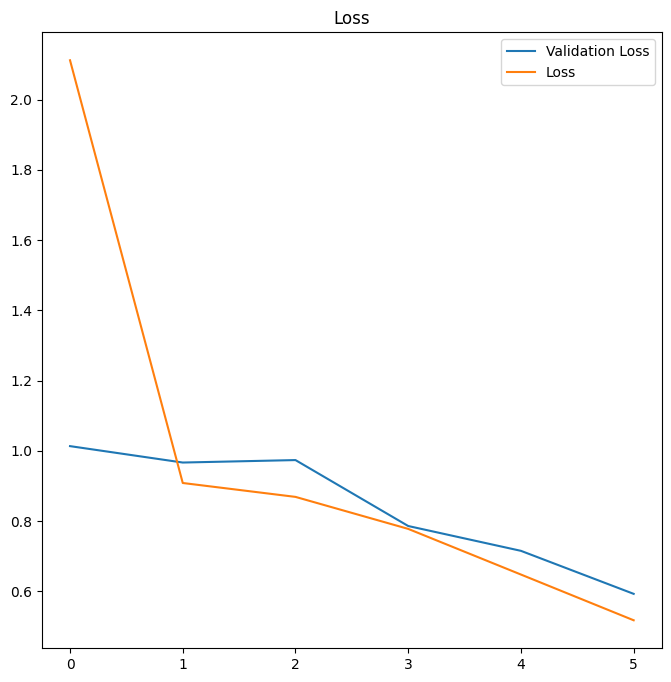

In [20]:
plt.figure(figsize=(8, 8))
plt.plot(range(6), history.history['val_loss'], label='Validation Loss')
plt.plot(range(6), history.history['loss'], label='Loss')
plt.title('Loss')
plt.legend()
plt.show()

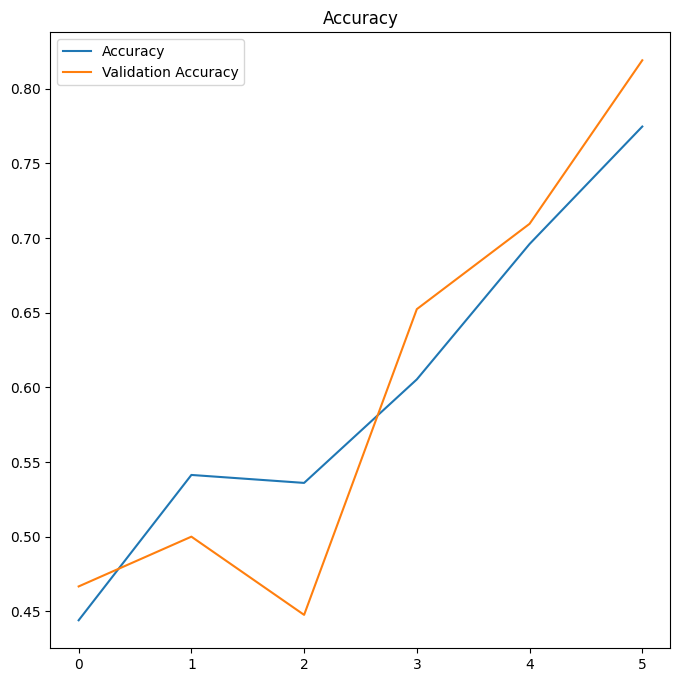

In [21]:
plt.figure(figsize=(8, 8))
plt.plot(range(6), history.history['accuracy'], label='Accuracy')
plt.plot(range(6), history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

## Model testing

In [22]:
testing_labels = []
testing_batch = []

for batch, labels in test_ds.take(1):
    testing_labels = labels.numpy()
    testing_batch = batch

real_labels = [classes[x] for x in testing_labels]

2024-11-18 16:21:35.516776: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [23]:
predictions = model.predict(testing_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


In [24]:
output = []
for pred in predictions:
    output.append(classes[np.argmax(pred)])

In [25]:
predicted_data = pd.DataFrame({'Predicion': output, 'Real class': real_labels})
predicted_data

,Predicion,Real class
0,Malignant cases,Malignant cases
1,Normal cases,Normal cases
2,Normal cases,Normal cases
3,Normal cases,Normal cases
4,Normal cases,Normal cases
5,Normal cases,Normal cases
6,Malignant cases,Malignant cases
7,Normal cases,Normal cases
8,Normal cases,Normal cases
9,Normal cases,Normal cases
